In [14]:
"""check if data read from seqrecord is same as data read by original tartanair dataloader
"""
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdata.datapipes as dp
from src.benchmarks.seqrecord.dataload_utils import InputConfig
from src.benchmarks.seqrecord.seqrecord import SeqRecord
from src.benchmarks.seqrecord.tartanloader import IterTartanAIRDatapipe, list2array
from src.data.tartanair.build import TartanAirVideoTransform, TartanAirNoTransform
from src.data.tartanair.tartanair_video import TartanAirVideoDataset

# load original tartanair dataset
modalities = ["image_left", "depth_left", "flow_flow"]
json_filepath = "/datadrive/azure_mounted_data/commondataset2/tartanair-release1/train_ann_abandonedfactory_easy.json"
transform = TartanAirNoTransform()
dataset = TartanAirVideoDataset(
    json_filepath,
    clip_len=1,
    seq_len=16,
    modalities=modalities,
    transform=transform,
    video_name_keyword=None,
)

In [15]:
# load iter style datapip
rootdir = "/datadrive/azure_mounted_data/commondataset2/tartanair-release1/abandonedfactory/records"
record = SeqRecord.load_record_from_dict(rootdir)
record.rootdir = rootdir
segment_len = 16
# configs from input modalities
config_path = "/home/azureuser/AutonomousSystemsResearch/dataloader-benchmark/src/benchmarks/seqrecord/config.yaml"
with open(config_path, mode="r") as f:
    import yaml

    config = yaml.safe_load(f)["inputs"]

input_config = InputConfig()
for key, modal in config.items():
    modal["kwargs"]["name"] = key
    input_config.add_input(modal)
datapipe = IterTartanAIRDatapipe(record, segment_len, None)
datapipe = dp.iter.Mapper(datapipe, fn=list2array)
#datapipe = dp.iter.Mapper(datapipe, fn=input_config.train_transform)

torch.float32
torch.float32
torch.Size([1, 480, 640])
torch.Size([480, 640])
torch.Size([2, 480, 640])
torch.Size([480, 640, 2])


/datadrive/anaconda3/envs/dataloader-benchmark/lib/python3.8/site-packages/torch/testing/_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)


AssertionError: Tensor-likes are not close!

Mismatched elements: 307120 / 307200 (100.0%)
Greatest absolute difference: 6.139556884765625 at index (479, 177) (up to 1e-05 allowed)
Greatest relative difference: 4635.868610368638 at index (35, 609) (up to 0.0001 allowed)

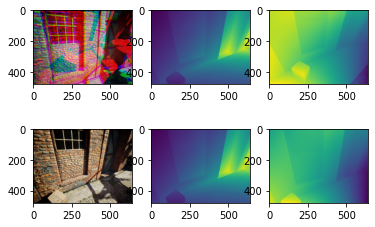

In [53]:
# mannually checking a few (no transform)
item_idx = 5
old_item = dataset[item_idx]
new_item = next(itertools.islice(datapipe, item_idx, None))

frame_idx = 5
fig, axs = plt.subplots(nrows=2, ncols=len(modalities), squeeze=False)
# rgb
modality = 'image_left'
old_rgb = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_rgb = torch.from_numpy(new_item[modality][frame_idx]).float().div(255)
print(old_rgb.dtype)
print(new_rgb.dtype)
old_rgb = old_rgb.permute(1, 2, 0)
axs[0, 0].imshow(np.asarray(old_rgb))
axs[1, 0].imshow(np.asarray(new_rgb))
# torch.testing.assert_allclose(old_rgb, new_rgb)
modality = 'depth_left'
old_depth = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_depth = torch.from_numpy(new_item[modality][frame_idx])
print(old_depth.shape)
print(new_depth.shape)
old_depth = old_depth[0]
axs[0, 1].imshow(np.asarray(old_depth))
axs[1, 1].imshow(np.asarray(new_depth))
torch.testing.assert_allclose(old_depth, new_depth)
modality = 'flow_flow'
old_flow = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_flow = torch.from_numpy(new_item[modality][frame_idx])
print(old_flow.shape)
print(new_flow.shape)
old_flow = old_flow[0]
new_flow = new_flow[:, :, 0]
axs[0, 2].imshow(np.asarray(old_flow))
axs[1, 2].imshow(np.asarray(new_flow))
torch.testing.assert_allclose(old_flow, new_flow)

torch.Size([1, 3, 16, 480, 640])
torch.float32


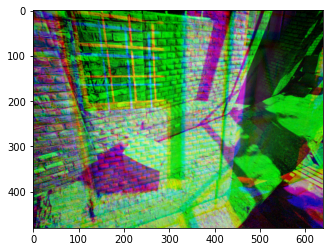

In [60]:
modality = "image_left"
old_rgb = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
print(old_item[modality].shape)
old_rgb = old_rgb.permute(1, 2, 0)

print(old_rgb.dtype)
old_rgb_reorder = np.empty_like(old_rgb)
old_rgb_reorder[:,:, 0]= old_rgb[:, :, 2]
old_rgb_reorder[:,:, 1]= old_rgb[:, :, 0]
old_rgb_reorder[:,:, 2]= old_rgb[:, :, 1]
plt.imshow(np.asarray(old_rgb_reorder))